In [5]:
import torch
import numpy as np
import matplotlib.pylab  as plt
from mpl_toolkits.mplot3d import Axes3D
from train_VAE import Net
from Data import ShapeNet_2048
from torch_geometric.data import DataLoader
from sklearn.model_selection import train_test_split
%matplotlib inline

In [6]:
path = '../data/shapenet_2048/'
batch_size = 32
dataset = ShapeNet_2048(path, split='trainval',categories='Chair')
indices = np.arange(len(dataset))
_, test_indices = train_test_split(indices, test_size=.25, random_state=42)
test_dataset = dataset[torch.tensor(test_indices)]
device = torch.device('cuda')
model = Net().to(device)
test_loader = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=1)
model.load_state_dict(torch.load('saved_models/pointVAECh30.pt',map_location=device))

<All keys matched successfully>

In [7]:
gen_data = {
    'pred': np.empty([len(dataset),2048,3]),
    'true': np.empty([len(dataset),2048,3])
}
model.eval()
for i,data in enumerate(test_loader):
    data = data.to(device)
    with torch.no_grad():
        begin = i*batch_size
        end = begin +data.category.size(0)
        gen_data['pred'][begin:end] = model(data)[0].cpu().numpy().reshape((-1,2048,3))
        gen_data['true'][begin:end] = data.x.cpu().numpy().reshape((-1,2048,3)) 

In [8]:
i

52

In [9]:
def plot_3d_point_cloud(x, y, z, show=True, show_axis=True, in_u_sphere=False, marker='.', s=8, alpha=.8, figsize=(15, 7), elev=20, azim=260, axis=None, title=None, *args, **kwargs):

    if axis is None:
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(111, projection='3d')        
    else:
        ax = axis
        fig = axis

    if title is not None:
        plt.title(title)

    sc = ax.scatter(x, y, z, marker=marker, s=s, alpha=alpha, *args, **kwargs)
    ax.view_init(elev=elev, azim=azim)

    if in_u_sphere:
        ax.set_xlim3d(-0.5, 0.5)
        ax.set_ylim3d(-0.5, 0.5)
        ax.set_zlim3d(-0.5, 0.5)
    else:
        miv = 0.7 * np.min([np.min(x), np.min(y), np.min(z)])  # Multiply with 0.7 to squeeze free-space.
        mav = 0.7 * np.max([np.max(x), np.max(y), np.max(z)])
        ax.set_xlim(miv, mav)
        ax.set_ylim(miv, mav)
        ax.set_zlim(miv, mav)
        plt.tight_layout()

    if not show_axis:
        plt.axis('off')

    if 'c' in kwargs:
        plt.colorbar(sc)

    if show:
        plt.show()

    return fig

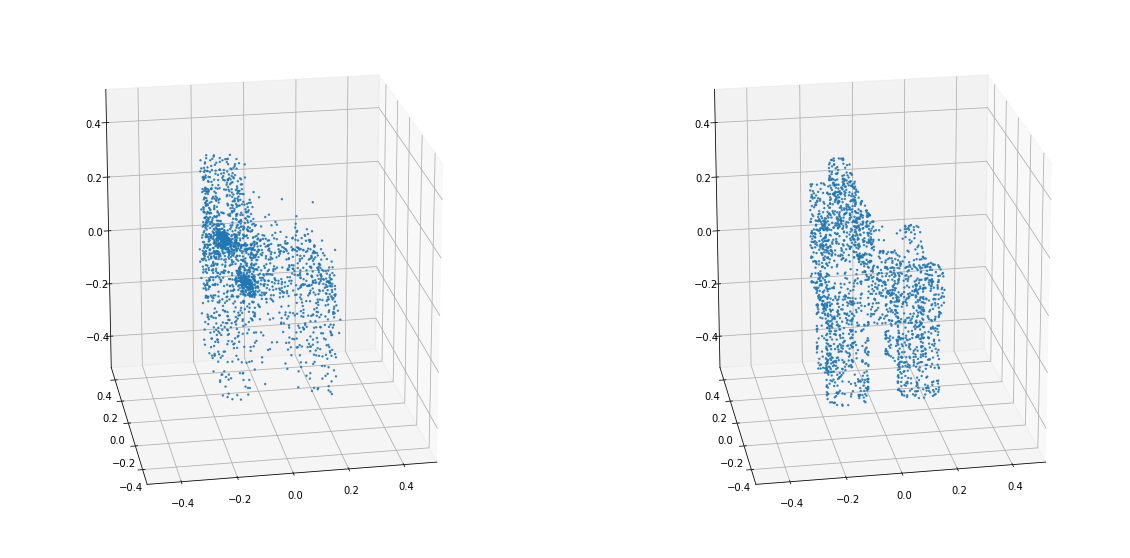

In [14]:
fig = plt.figure(figsize=(20,10))
ax_pred = fig.add_subplot(121, projection='3d')
ax_true = fig.add_subplot(122, projection='3d')
num = 10
plot_3d_point_cloud(gen_data['pred'][num][:,0], 
                    gen_data['pred'][num][:,1], 
                    gen_data['pred'][num][:,2], in_u_sphere=True,axis=ax_pred,show=False);
plot_3d_point_cloud(gen_data['true'][num][:,0], 
                    gen_data['true'][num][:,1], 
                    gen_data['true'][num][:,2], in_u_sphere=True,axis=ax_true,show=False);

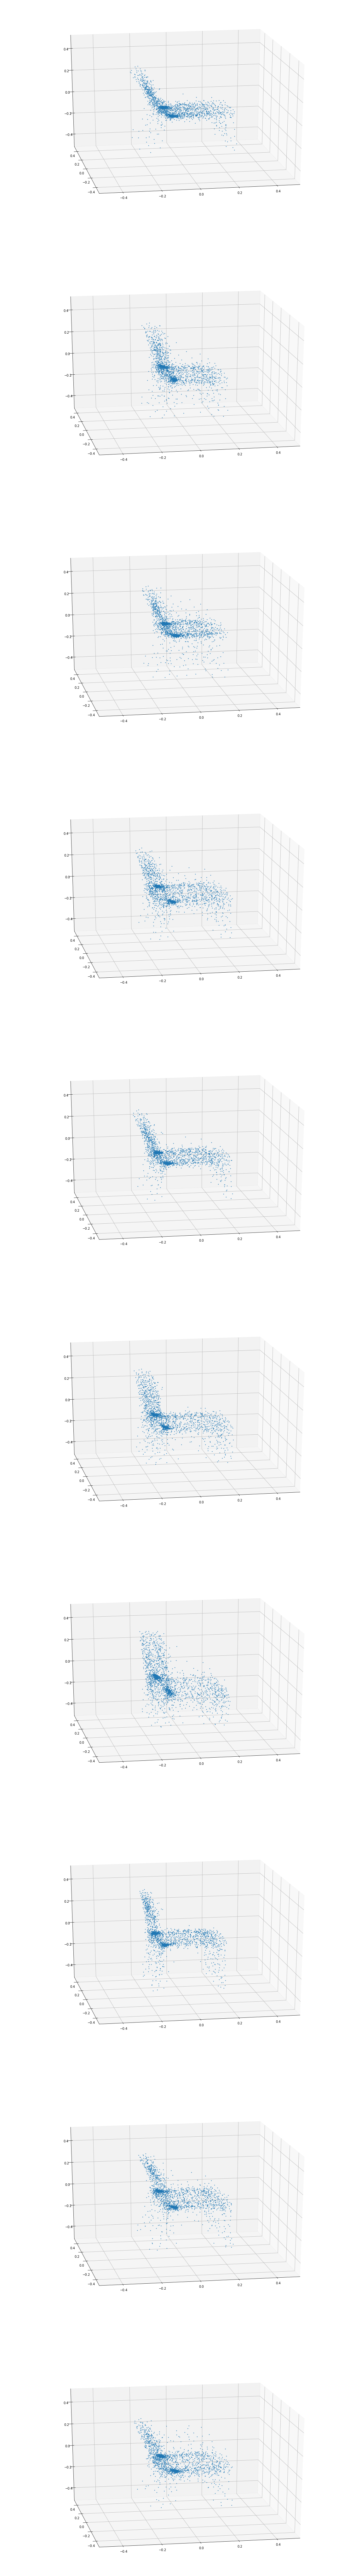

In [15]:
num_samples = 10
encode_dim = 128
rand_norm = torch.randn(num_samples, encode_dim).to(device)
fig = plt.figure(figsize=(20,15*num_samples))
for i in range(0,num_samples):
    sample = model.decode(rand_norm[i]).cpu().view(-1,3).detach()
    ax = fig.add_subplot(num_samples, 1, i+1, projection='3d')
    plot_3d_point_cloud(sample[:,0], 
                        sample[:,1], 
                        sample[:,2], in_u_sphere=True,axis=ax,show=False);

In [78]:
rand_norm.shape

torch.Size([10, 64])